In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np

from scipy.special import jv

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

# def get_mgrid(sidelen, dim=2):
#     '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
#     sidelen: int
#     dim: int'''
#     tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
#     mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
#     mgrid = mgrid.reshape(-1, dim)
#     return mgrid

In [2]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [3]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [16]:
class PipeFlow:
    def __init__(self, Wo=10, Po=-1, Pn=None):
        
        self.Wo = Wo
        self.Po = Po
        self.Pn = Pn

    def velocity(self, x, y, t):
        u = -1/4*self.Wo**2*self.Po*(1-y**2)
        if not self.Pn==None:
            for n in (np.arange(len(self.Pn))+1):
                zn = complex(0,1)**(3/2)*n**(1/2)
                u += np.real(complex(0,1)*self.Pn[n-1]/n*(1-jv(0,self.Wo*zn*y)/jv(0,self.Wo*zn))*np.exp(2*np.pi*complex(0,1)*n*t))
        u = u*(y**2<=1)
        v = np.zeros_like(u)
        
        return u,v

In [17]:

Pn = [  complex(-0.5060,0.1245),
        complex(0.0802,0.0886),
        complex(0.0591,0.0251),
        complex(0.0228,0.0244),
        complex(0.0141,0.0071),
        complex(0.0112,0.0107),
        complex(0.0065,0.0056),
        complex(0.0067,0.0050),
        complex(0.0030,0.0040),
        complex(0.0044,0.0030),
        complex(0.0000,0.3710),
        complex(0.1493,0.0754),
        complex(0.0161,0.0103),
        complex(0.0166,0.0082),
        complex(-0.0002,0.0046),
        complex(0.0063,0.0001),
        complex(0.0008,0.0013),
        complex(0.0021,-0.0012),
        complex(0.0009,0.0015),
        complex(0.0001,-0.0001)]
pipe = PipeFlow(Po=-0.05,Pn=[complex(1,0.3),complex(-0.5,0.6),complex(0.1,0.1)],Wo=5)
Nx = 32
Nt = 32
x,y,t = np.meshgrid(np.linspace(0,8,4*Nx),np.linspace(-1,1,Nx),np.linspace(0,1,Nt))
u,v = pipe.velocity(x,y,t)
X = np.concatenate((x.reshape((Nx**2*4*Nt,1)),y.reshape((Nx**2*4*Nt,1)),t.reshape((Nx**2*4*Nt,1))),axis=1)
U = np.concatenate((u.reshape((Nx**2*4*Nt,1)),v.reshape((Nx**2*4*Nt,1))),axis=1)
X = torch.from_numpy(X).float().cuda()
U = torch.from_numpy(U).float().cuda()

N = 2**15
Xr = np.random.rand(N,3)
xr = Xr[:,0]
yr = Xr[:,1]
tr = Xr[:,2]
ur,vr = pipe.velocity(xr,yr,tr)
# Ur = np.concatenate((ur,vr),axis=1)
Xr = torch.from_numpy(Xr).float().cuda()
# Ur = torch.from_numpy(Ur).float().cuda()
Xr.size()
# Ur.size()

# for tt in np.arange(Nt):
#     fig, axes = plt.subplots(1,1, figsize=(16,4))
#     plt.quiver(x[:,:,tt],y[:,:,tt],u[:,:,tt],v[:,:,tt],scale=50)
#     plt.show()

torch.Size([32768, 3])

In [18]:
net = Siren(in_features=3, out_features=2, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)
net.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [19]:
total_steps = 1000

optim = torch.optim.Adam(lr=1e-4, params=net.parameters())

for step in range(total_steps):
    Up, X = net(X)    
    loss = ((U - Up)**2).mean()

    optim.zero_grad()
    loss.backward()
    optim.step()
    
    print("Loss " + str(step) + ": " + str(loss.item()))

Loss 0: 0.308351993560791
Loss 1: 0.28758537769317627
Loss 2: 0.2857901453971863
Loss 3: 0.2785252332687378
Loss 4: 0.2717602849006653
Loss 5: 0.2627072036266327
Loss 6: 0.24955643713474274
Loss 7: 0.2356467843055725
Loss 8: 0.219149649143219
Loss 9: 0.19900260865688324
Loss 10: 0.17798465490341187
Loss 11: 0.15499424934387207
Loss 12: 0.13468694686889648
Loss 13: 0.11689256876707077
Loss 14: 0.10442768782377243
Loss 15: 0.09531678259372711
Loss 16: 0.0884876549243927
Loss 17: 0.08060961961746216
Loss 18: 0.07268159091472626
Loss 19: 0.06509721279144287
Loss 20: 0.06076131388545036
Loss 21: 0.058177024126052856
Loss 22: 0.054902125149965286
Loss 23: 0.04988287761807442
Loss 24: 0.04539746791124344
Loss 25: 0.042052388191223145
Loss 26: 0.03877157345414162
Loss 27: 0.03505665063858032
Loss 28: 0.031600501388311386
Loss 29: 0.029072510078549385
Loss 30: 0.027135543525218964
Loss 31: 0.02499585784971714
Loss 32: 0.022785235196352005
Loss 33: 0.021067652851343155
Loss 34: 0.019555952399969

Loss 265: 0.00014841760275885463
Loss 266: 0.0001406251103617251
Loss 267: 0.00012208663974888623
Loss 268: 0.0001243299775524065
Loss 269: 0.00013602986291516572
Loss 270: 0.00013189765741117299
Loss 271: 0.0001188857204397209
Loss 272: 0.00011753092985600233
Loss 273: 0.00012531920219771564
Loss 274: 0.00012573887943290174
Loss 275: 0.00011729390826076269
Loss 276: 0.0001124530317611061
Loss 277: 0.00011582444130908698
Loss 278: 0.00011916914081666619
Loss 279: 0.00011606645421124995
Loss 280: 0.00011045602150261402
Loss 281: 0.00010891305282711983
Loss 282: 0.00011132559302495793
Loss 283: 0.00011257822188781574
Loss 284: 0.00011013908078894019
Loss 285: 0.00010652150376699865
Loss 286: 0.00010511359141673893
Loss 287: 0.00010609500168357044
Loss 288: 0.0001070093858288601
Loss 289: 0.00010604159615468234
Loss 290: 0.00010372567339800298
Loss 291: 0.00010182993719354272
Loss 292: 0.00010134570038644597
Loss 293: 0.00010176640353165567
Loss 294: 0.00010192723129875958
Loss 295: 0.000

Loss 522: 0.00027015089290216565
Loss 523: 7.688015466555953e-05
Loss 524: 0.00022042676573619246
Loss 525: 0.0001415271544829011
Loss 526: 0.0001015096131595783
Loss 527: 0.000191844766959548
Loss 528: 7.243422442115843e-05
Loss 529: 0.00013828781084157526
Loss 530: 0.00012288763537071645
Loss 531: 7.014932634774595e-05
Loss 532: 0.00013598884106613696
Loss 533: 7.26137513993308e-05
Loss 534: 9.011941438075155e-05
Loss 535: 0.00010474096052348614
Loss 536: 5.8272045862395316e-05
Loss 537: 9.756420331541449e-05
Loss 538: 7.295735849766061e-05
Loss 539: 6.408253102563322e-05
Loss 540: 8.737486496102065e-05
Loss 541: 5.6301389122381806e-05
Loss 542: 7.046472455840558e-05
Loss 543: 7.115784683264792e-05
Loss 544: 5.265966319711879e-05
Loss 545: 7.012294372543693e-05
Loss 546: 5.8114321291213855e-05
Loss 547: 5.425475683296099e-05
Loss 548: 6.461963494075462e-05
Loss 549: 5.1084272854495794e-05
Loss 550: 5.5544420320075005e-05
Loss 551: 5.798184429295361e-05
Loss 552: 4.8334404709748924e-0

Loss 774: 2.2499181795865297e-05
Loss 775: 2.2656806322629564e-05
Loss 776: 2.3042972316034138e-05
Loss 777: 2.3914833946037106e-05
Loss 778: 2.5836776330834255e-05
Loss 779: 3.0035484087420627e-05
Loss 780: 3.9276506868191063e-05
Loss 781: 5.9587393479887396e-05
Loss 782: 0.00010486619430594146
Loss 783: 0.00020423941896297038
Loss 784: 0.00042367519927211106
Loss 785: 0.0008716824813745916
Loss 786: 0.0017230950761586428
Loss 787: 0.0028264892753213644
Loss 788: 0.0033980265725404024
Loss 789: 0.0019348764326423407
Loss 790: 0.00016934068116825074
Loss 791: 0.0008544031297788024
Loss 792: 0.0014810331631451845
Loss 793: 0.0002932587522082031
Loss 794: 0.0005087185418233275
Loss 795: 0.0009618275216780603
Loss 796: 0.00015560092288069427
Loss 797: 0.000522249611094594
Loss 798: 0.0005674019339494407
Loss 799: 0.00010086174734169617
Loss 800: 0.0005175365367904305
Loss 801: 0.00023368382244370878
Loss 802: 0.00018769700545817614
Loss 803: 0.0003874208778142929
Loss 804: 7.1605099947191

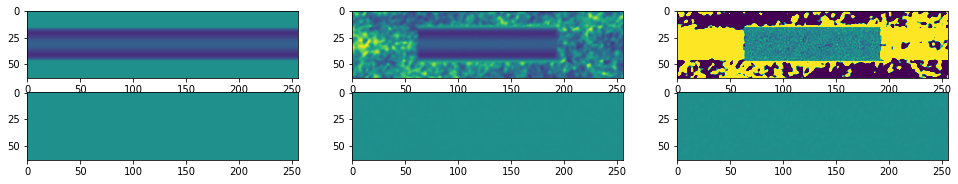

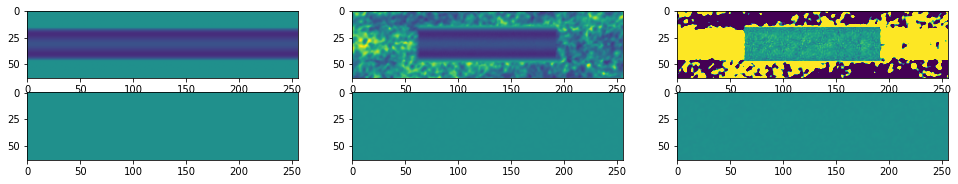

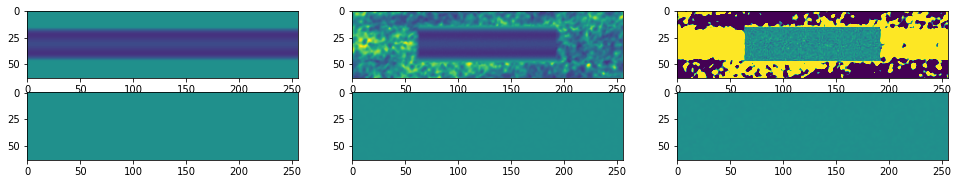

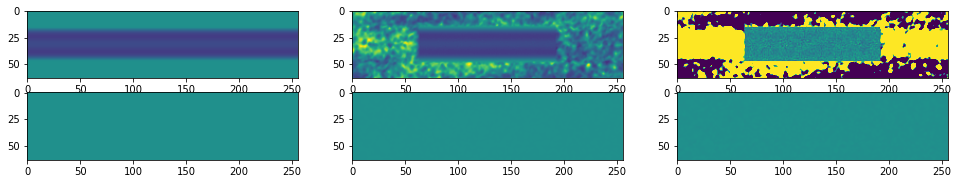

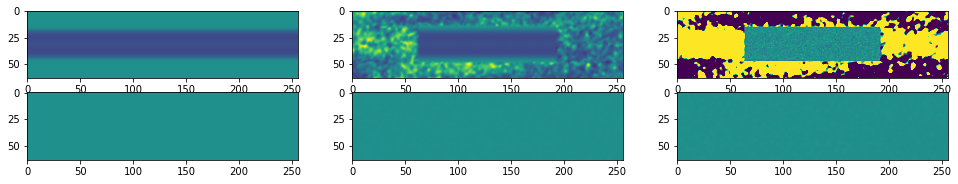

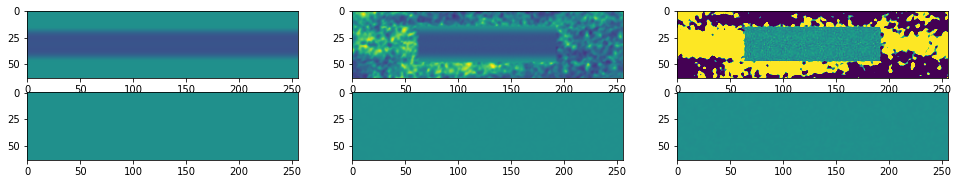

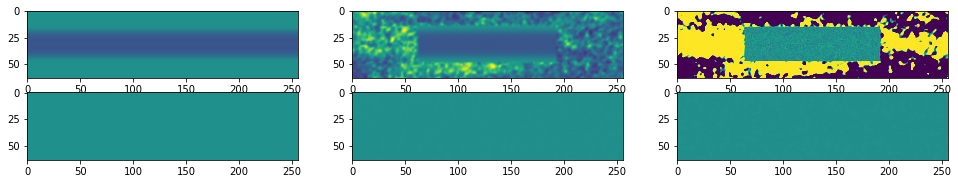

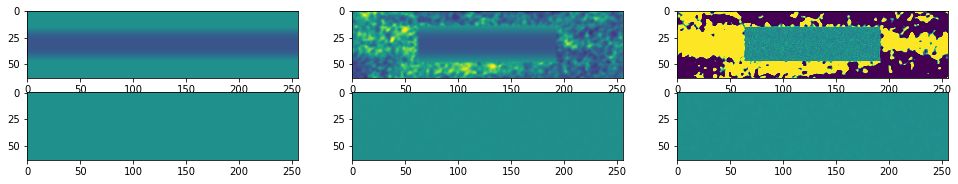

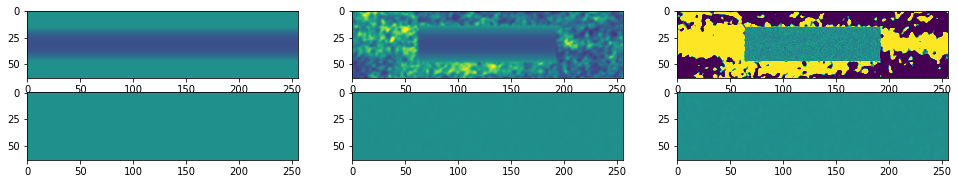

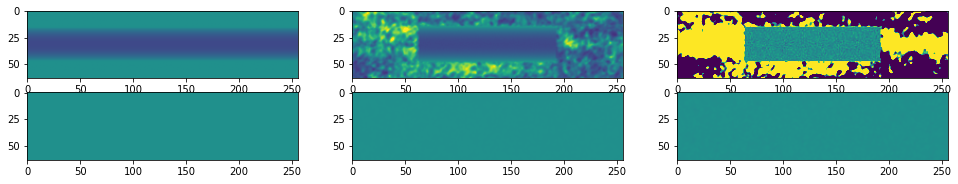

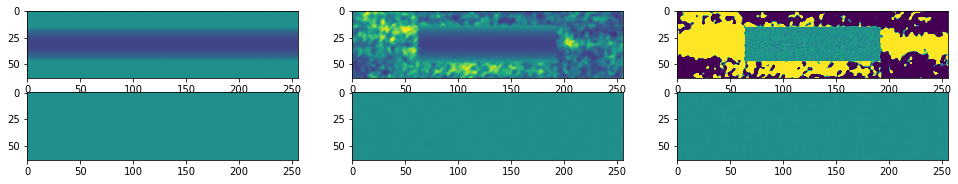

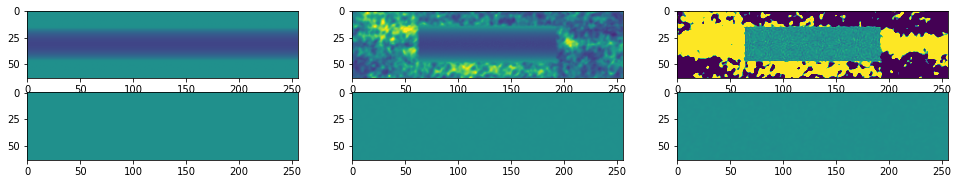

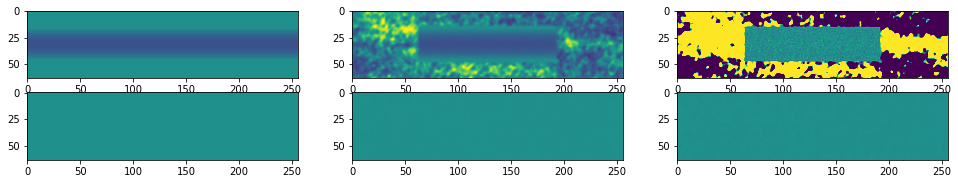

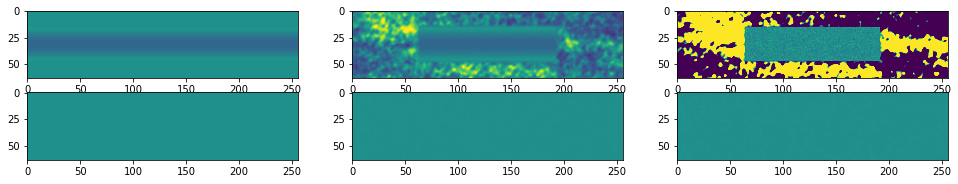

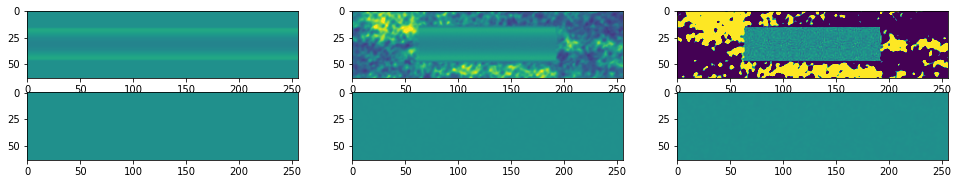

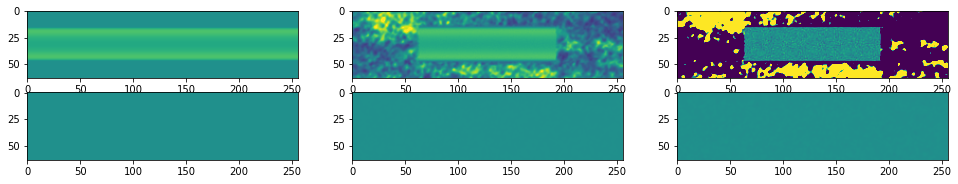

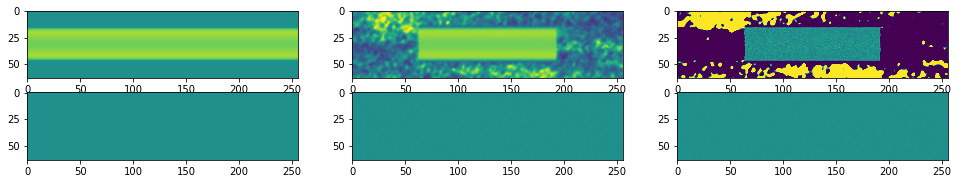

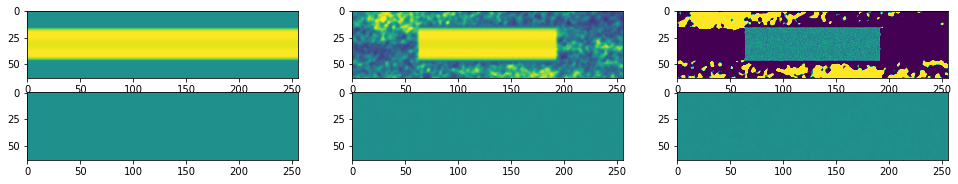

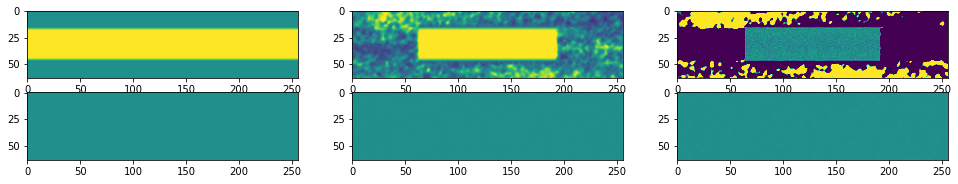

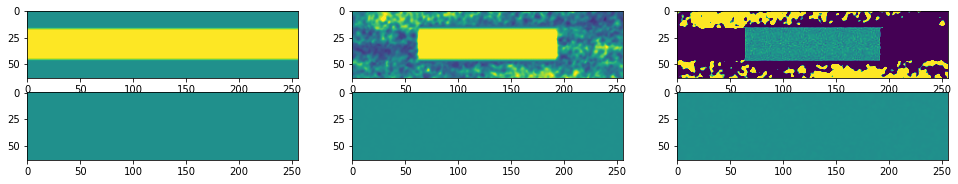

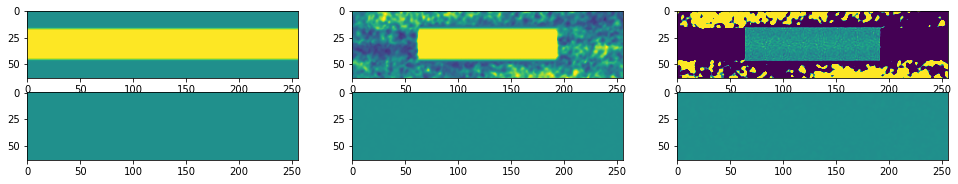

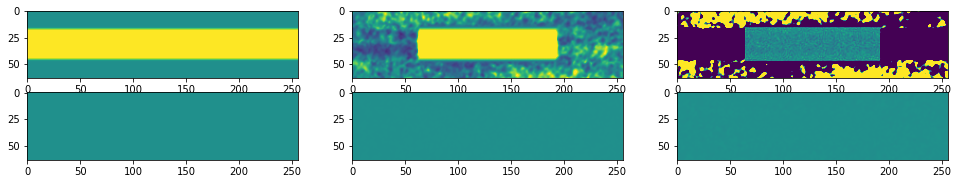

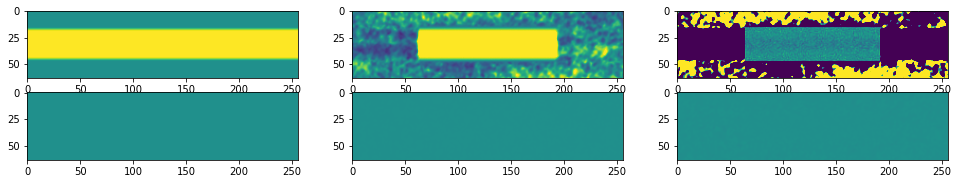

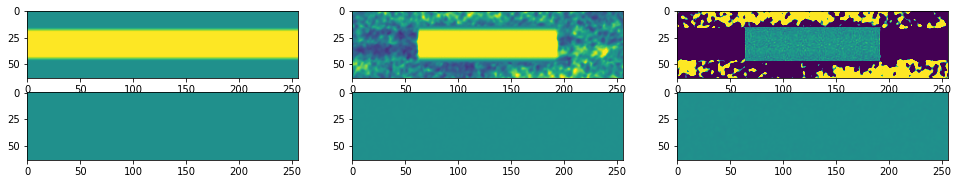

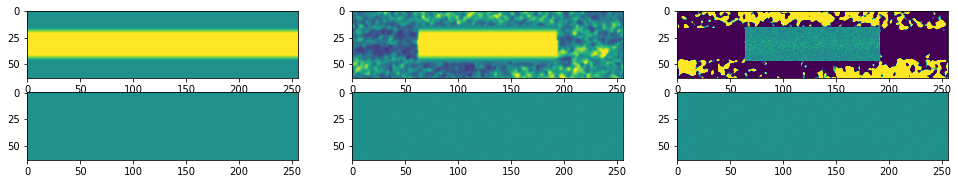

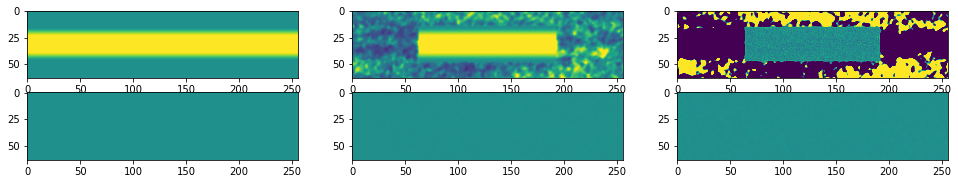

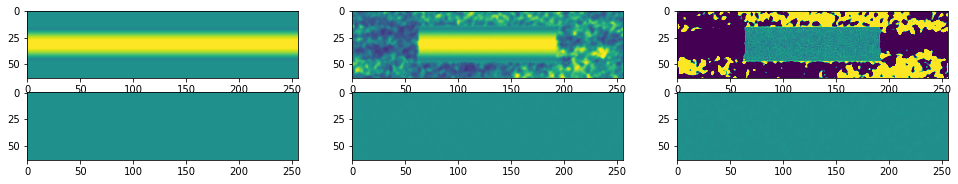

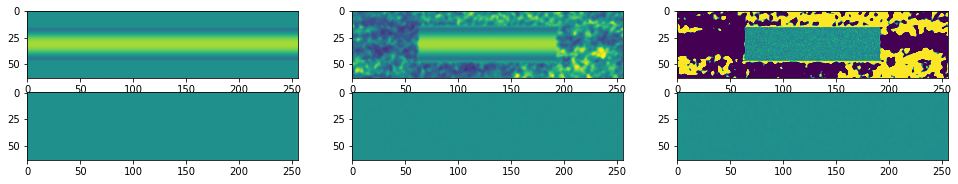

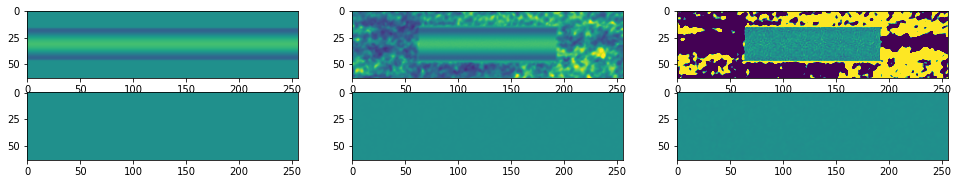

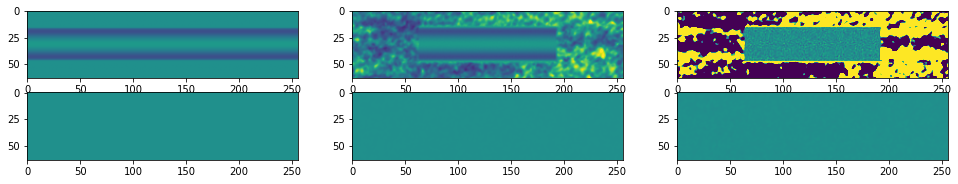

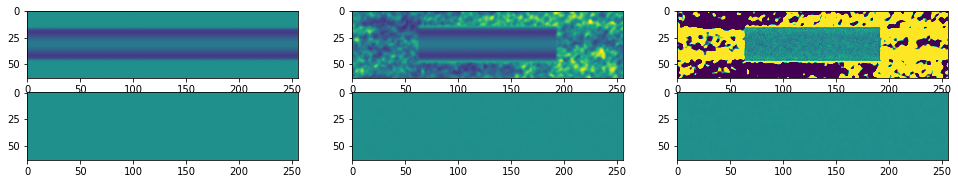

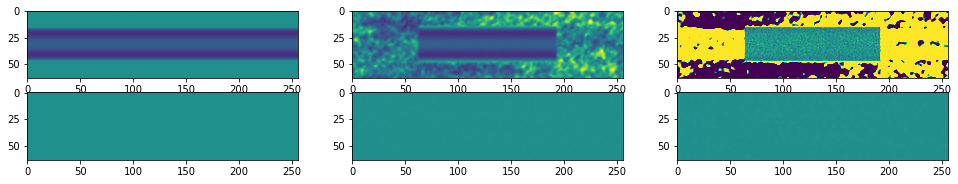

In [20]:
Nxt = 64
Ntt = Nt
xt,yt,tt = np.meshgrid(np.linspace(-4,12,4*Nxt),np.linspace(-2,2,Nxt),np.linspace(0,1,Ntt))
ut,vt = pipe.velocity(xt,yt,tt)
Xt = np.concatenate((xt.reshape((Nxt**2*4*Ntt,1)),yt.reshape((Nxt**2*4*Ntt,1)),tt.reshape((Nxt**2*4*Ntt,1))),axis=1)
Xt = torch.from_numpy(Xt).float().cuda()
Upt,Xt = net(Xt)

Upt = Upt.cpu().detach().numpy().reshape((Nxt,4*Nxt,Ntt,2))
upt = Upt[:,:,:,0]
vpt = Upt[:,:,:,1]
for tn in np.arange(Nt):
    fig, axes = plt.subplots(2,3, figsize=(16.5,2.75))
    axes[0,0].imshow(ut[:,:,tn],vmin=-1,vmax=1)
    axes[0,1].imshow(upt[:,:,tn],vmin=-1,vmax=1)
    axes[0,2].imshow(upt[:,:,tn]-ut[:,:,tn],vmin=-0.05,vmax=0.05)
    axes[1,0].imshow(vt[:,:,tn],vmin=-1,vmax=1)
    axes[1,1].imshow(vpt[:,:,tn],vmin=-1,vmax=1)
    axes[1,2].imshow(vpt[:,:,tn]-vt[:,:,tn],vmin=-0.05,vmax=0.05)
    
    plt.show()